<a href="https://colab.research.google.com/github/omer-ulucan/pointnet-lite-modelnet10/blob/main/pointnet_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet Lite: ModelNet10 3D Point Cloud Classification on GPU
This Jupyter Notebook trains a PointNet Lite model on the ModelNet10 dataset using TensorFlow 2 and ensures execution on GPU if available.

## Installation
Install required packages:
```bash
!pip install tensorflow numpy matplotlib trimesh scikit-learn tqdm requests
```

In [ ]:
!pip install tensorflow numpy matplotlib trimesh scikit-learn tqdm requests

## Imports

In [ ]:
import os
import glob
import zipfile
import requests
import numpy as np
import tensorflow as tf
import trimesh
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU detected, running on CPU.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Settings
Adjust these parameters as needed

In [ ]:
BATCH_SIZE = 32
NUM_POINTS = 1024
EPOCHS = 90
DATA_URL = 'http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip'
DATA_DIR = 'ModelNet10'

## Robust Download and Extraction
Attempts download twice if zip is corrupted

In [ ]:
def download_and_extract():
    zip_path = f"{DATA_DIR}.zip"
    if not os.path.exists(DATA_DIR):
        for attempt in range(2):
            if not os.path.exists(zip_path):
                print('Downloading ModelNet10...')
                resp = requests.get(DATA_URL, stream=True)
                resp.raise_for_status()
                with open(zip_path, 'wb') as f:
                    for chunk in resp.iter_content(chunk_size=8192):
                        f.write(chunk)
            try:
                print('Extracting ModelNet10...')
                with zipfile.ZipFile(zip_path, 'r') as z:
                    z.extractall()
                print('Extraction complete.')
                break
            except zipfile.BadZipFile:
                print('Bad zip file, re-downloading...')
                os.remove(zip_path)
        else:
            raise RuntimeError('Failed to obtain valid ModelNet10.')

Execute download & extraction

In [ ]:
download_and_extract()

## Prepare Point Cloud Data
Sample NUM_POINTS points from each mesh, normalize to unit sphere

In [ ]:
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
class_map = {cls: i for i, cls in enumerate(classes)}

def load_point_clouds(split_dir):
    data, labels = [], []
    for cls in classes:
        mesh_paths = glob.glob(os.path.join(DATA_DIR, cls, split_dir, '*.off'))
        for path in tqdm(mesh_paths, desc=f"Loading {split_dir}/{cls}"):
            mesh = trimesh.load(path, process=False)
            pts = mesh.sample(NUM_POINTS)
            centroid = pts.mean(axis=0)
            pts -= centroid
            scale = np.linalg.norm(pts, axis=1).max()
            pts /= scale
            data.append(pts)
            labels.append(class_map[cls])
    return np.stack(data), np.array(labels)

X_train, y_train = load_point_clouds('train')
X_test, y_test = load_point_clouds('test')

Loading test/toilet: 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


## Create TensorFlow Dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Define PointNet Lite Model within GPU Context

In [ ]:
strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0" if gpus else "/CPU:0")
with strategy.scope():
    inputs = tf.keras.Input(shape=(NUM_POINTS, 3), name='points')
    x = tf.keras.layers.Conv1D(64, 1, activation='relu')(inputs)
    x = tf.keras.layers.Conv1D(128, 1, activation='relu')(x)
    x = tf.keras.layers.Conv1D(256, 1, activation='relu')(x)
    feat = tf.keras.layers.GlobalMaxPooling1D()(x)
    d = tf.keras.layers.Dense(256, activation='relu')(feat)
    d = tf.keras.layers.Dense(128, activation='relu')(d)
    outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(d)
    model = tf.keras.Model(inputs, outputs, name='PointNet_Lite')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "PointNet_Lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ points (InputLayer)             │ (None, 1024, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1024, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1024, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1024, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,578 (553.04 KB)

 Trainable params: 141,578 (553.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5771 - loss: 1.6403 - val_accuracy: 0.3623 - val_loss: 2.3040
Epoch 2/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5912 - loss: 1.3425 - val_accuracy: 0.5044 - val_loss: 1.5032
Epoch 3/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7476 - loss: 0.7697 - val_accuracy: 0.5551 - val_loss: 1.1721
Epoch 4/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8139 - loss: 0.6096 - val_accuracy: 0.5352 - val_loss: 1.2091
Epoch 5/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8055 - loss: 0.5910 - val_accuracy: 0.5738 - val_loss: 1.0951
Epoch 6/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8119 - loss: 0.5519 - val_accuracy: 0.6641 - val_loss: 0.9757
Epoch 7/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8338 - loss: 0.4830 - val_accuracy: 0.6773 - val_loss: 0.9547
Epoch 8/90
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8225 - loss: 0.5175 - val_accu

## Evaluate Model

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8159 - loss: 0.7398
Test Loss: 0.5321, Test Accuracy: 0.8568


## Plot Training Curve

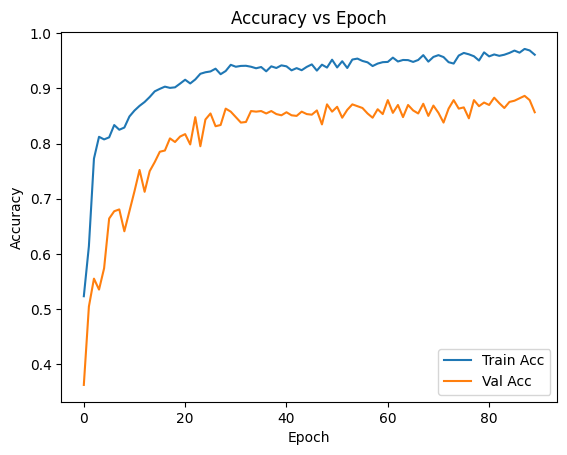

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Sample Predictions

In [ ]:
for batch_x, batch_y in test_ds.take(1):
    preds = model.predict(batch_x)
    pred_idxs = np.argmax(preds, axis=1)
    print('True:', [classes[i] for i in batch_y[:5].numpy()])
    print('Pred:', [classes[i] for i in pred_idxs[:5]])
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
True: ['bathtub', 'bathtub', 'bathtub', 'bathtub', 'bathtub']
Pred: ['toilet', 'bathtub', 'table', 'toilet', 'bathtub']
